In [59]:
import numpy
import pandas
from matplotlib import pyplot

%matplotlib inline

In [60]:
season_averages = pandas.read_csv("SeasonAverages.csv")
season_averages["Season"] = season_averages["Season"].astype(numpy.int32)
season_averages["Team_Id"] = season_averages["Team_Id"].astype(numpy.int32)
regular_season = pandas.read_csv("RegularSeasonCompactResults.csv")

In [61]:
season_averages.head()

,score,fgm,fga,fgm3,fga3,ftm,fta,or,dr,ast,to,stl,blk,pf,Team_Id,Season,Team_Name
0,57.250000,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000,1102,2003,Air Force
1,78.777778,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852,1103,2003,Akron
2,69.285714,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,12.107143,13.285714,6.607143,3.785714,18.035714,1104,2003,Alabama
3,71.769231,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,14.538462,18.653846,9.307692,2.076923,20.230769,1105,2003,Alabama A&M
4,63.607143,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,11.678571,17.035714,8.357143,3.142857,18.178571,1106,2003,Alabama St


In [62]:
matchup_columns = ["Season", "home_score", "home_team", "away_score", "away_team"]

matchup_rows = []
for id, row in regular_season.iterrows():
    matchup_rows.append(list(row[["Season", "Wscore", "Wteam", "Lscore", "Lteam"]]))
    matchup_rows.append(list(row[["Season", "Lscore", "Lteam", "Wscore", "Wteam"]]))
    
matchups = pandas.DataFrame(matchup_rows, columns=matchup_columns)

In [63]:
matchups.head()

,Season,home_score,home_team,away_score,away_team
0,1985,81,1228,64,1328
1,1985,64,1328,81,1228
2,1985,77,1106,70,1354
3,1985,70,1354,77,1106
4,1985,63,1112,56,1223


In [64]:
len(matchups)

301368

In [65]:
matchups.columns

Index([u'Season', u'home_score', u'home_team', u'away_score', u'away_team'], dtype='object')

In [66]:
matchups = matchups.merge(season_averages, how="inner",
                          left_on=["Season", "home_team"],
                          right_on=["Season", "Team_Id"],
                          suffixes=("_woah", "_home"))

matchups = matchups.merge(season_averages, how="inner",
                          left_on=["Season", "away_team"],
                          right_on=["Season", "Team_Id"],
                          suffixes=("_home", "_away"))

In [67]:
matchups.columns

Index([u'Season', u'home_score', u'home_team', u'away_score', u'away_team',
       u'score_home', u'fgm_home', u'fga_home', u'fgm3_home', u'fga3_home',
       u'ftm_home', u'fta_home', u'or_home', u'dr_home', u'ast_home',
       u'to_home', u'stl_home', u'blk_home', u'pf_home', u'Team_Id_home',
       u'Team_Name_home', u'score_away', u'fgm_away', u'fga_away',
       u'fgm3_away', u'fga3_away', u'ftm_away', u'fta_away', u'or_away',
       u'dr_away', u'ast_away', u'to_away', u'stl_away', u'blk_away',
       u'pf_away', u'Team_Id_away', u'Team_Name_away'],
      dtype='object')

In [68]:
input_columns = [col for col in matchups.columns 
                    if not (col.startswith("Team_")) 
                    and (col.endswith("_away") or col.endswith("_home"))]

In [69]:
input_columns

['score_home',
 'fgm_home',
 'fga_home',
 'fgm3_home',
 'fga3_home',
 'ftm_home',
 'fta_home',
 'or_home',
 'dr_home',
 'ast_home',
 'to_home',
 'stl_home',
 'blk_home',
 'pf_home',
 'score_away',
 'fgm_away',
 'fga_away',
 'fgm3_away',
 'fga3_away',
 'ftm_away',
 'fta_away',
 'or_away',
 'dr_away',
 'ast_away',
 'to_away',
 'stl_away',
 'blk_away',
 'pf_away']

In [70]:
matchups["home_win"] = matchups["home_score"] > matchups["away_score"]

In [71]:
matchups["home_win"].value_counts()

True     76636
False    76636
Name: home_win, dtype: int64

In [72]:
x_unscaled = matchups[input_columns] 
from sklearn import preprocessing
    
scaler = preprocessing.RobustScaler()
x = scaler.fit_transform(x_unscaled)
y = matchups["home_win"]

In [73]:
from sklearn import cross_validation

kfold = cross_validation.StratifiedKFold(y, n_folds=5, shuffle=True)

In [82]:
from sklearn import ensemble
from sklearn import grid_search

model_class = ensemble.GradientBoostingClassifier()
#model = ensemble.RandomForestClassifier()

params = {'n_estimators': scipy.stats.randint(50, 150),
          'learning_rate': scipy.stats.expon(scale=.1),
          'max_depth': [2, 3, 4, 5],
          'subsample':scipy.stats.uniform(loc=0.5, scale=0.5)}

n_iter = 80

models = []
for train_index, test_index in kfold:
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    g_search = grid_search.RandomizedSearchCV(model_class,
                                                 param_distributions=params,
                                                 n_iter=n_iter,
                                                 n_jobs=16)
    g_search.fit(x_train, y_train)
    print "score:", g_search.score(x_test, y_test)
    models.append(g_search)


score: 0.71056236952
score: 0.718470672669
score: 0.713185881125
score: 0.713707835845
score: 0.715338944347


In [83]:
import cPickle as pickle

In [86]:
pickle.dump(models, open("2017-03-15_gbc_cv_opt.pkl", 'w'))

## Load 2017 data

In [87]:
import operator
submission = pandas.read_csv("SampleSubmission.csv")
sub_split = submission["Id"].str.split("_")
submission["Season"] = sub_split.map(operator.itemgetter(0)).astype(numpy.int32)
submission["home_team"] = sub_split.map(operator.itemgetter(1)).astype(numpy.int32)
submission["away_team"] = sub_split.map(operator.itemgetter(2)).astype(numpy.int32)


In [88]:
submission.head()

,Id,Pred,Season,home_team,away_team
0,2017_1112_1116,0.5,2017,1112,1116
1,2017_1112_1124,0.5,2017,1112,1124
2,2017_1112_1137,0.5,2017,1112,1137
3,2017_1112_1139,0.5,2017,1112,1139
4,2017_1112_1153,0.5,2017,1112,1153


In [89]:
submission = submission.merge(season_averages, how="inner",
                          left_on=["Season", "home_team"],
                          right_on=["Season", "Team_Id"],
                          suffixes=("_woah", "_home"))

submission = submission.merge(season_averages, how="inner",
                          left_on=["Season", "away_team"],
                          right_on=["Season", "Team_Id"],
                          suffixes=("_home", "_away"))

In [90]:
submission.head()

,Id,Pred,Season,home_team,away_team,score_home,fgm_home,fga_home,fgm3_home,fga3_home,...,fta_away,or_away,dr_away,ast_away,to_away,stl_away,blk_away,pf_away,Team_Id_away,Team_Name_away
0,2017_1112_1116,0.5,2017,1112,1116,76.264706,26.205882,55.088235,6.735294,16.941176,...,23.352941,11.323529,24.941176,14.088235,11.735294,7.529412,4.735294,20.588235,1116,Arkansas
1,2017_1112_1124,0.5,2017,1112,1124,76.264706,26.205882,55.088235,6.735294,16.941176,...,18.903226,12.677419,24.935484,15.483871,13.419355,5.129032,4.870968,17.677419,1124,Baylor
2,2017_1116_1124,0.5,2017,1116,1124,79.794118,27.735294,60.176471,6.529412,17.941176,...,18.903226,12.677419,24.935484,15.483871,13.419355,5.129032,4.870968,17.677419,1124,Baylor
3,2017_1112_1137,0.5,2017,1112,1137,76.264706,26.205882,55.088235,6.735294,16.941176,...,20.794118,8.617647,25.823529,14.617647,13.264706,7.176471,3.823529,18.529412,1137,Bucknell
4,2017_1116_1137,0.5,2017,1116,1137,79.794118,27.735294,60.176471,6.529412,17.941176,...,20.794118,8.617647,25.823529,14.617647,13.264706,7.176471,3.823529,18.529412,1137,Bucknell


In [91]:
sub_x = scaler.transform(submission[input_columns])

(array([   0.,    0.,    2.,   37.,   73.,  146.,  138.,  215.,  230.,
         256.,  265.,  221.,  221.,  186.,  138.,  107.,   38.,    5.,
           0.,    0.]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ]),
 <a list of 20 Patch objects>)

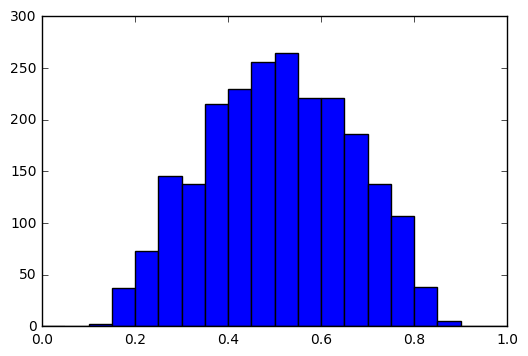

In [92]:
pyplot.hist(map(operator.itemgetter(1), model.predict_proba(sub_x)),
            bins=numpy.linspace(0, 1, 21))

(array([  1.00000000e+00,   1.33000000e+02,   6.40000000e+02,
          1.19400000e+03,   1.74700000e+03,   2.11100000e+03,
          2.23400000e+03,   2.35400000e+03,   2.48300000e+03,
          2.42700000e+03,   2.42500000e+03,   2.48200000e+03,
          2.32000000e+03,   2.18500000e+03,   2.06600000e+03,
          1.71100000e+03,   1.30500000e+03,   6.77000000e+02,
          1.59000000e+02,   0.00000000e+00]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ]),
 <a list of 20 Patch objects>)

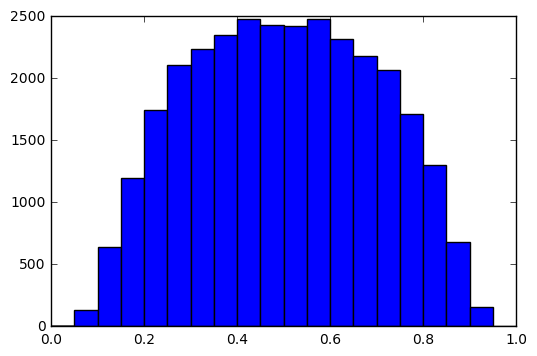

In [93]:
pyplot.hist(map(operator.itemgetter(1), model.predict_proba(x_test)),
            bins=numpy.linspace(0, 1, 21))

(array([   0.,    0.,    6.,   46.,   77.,  159.,  167.,  226.,  228.,
         254.,  238.,  242.,  220.,  168.,  128.,   81.,   34.,    4.,
           0.,    0.]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ]),
 <a list of 20 Patch objects>)

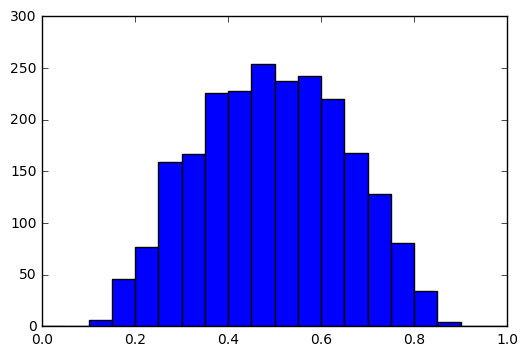

In [94]:
import operator
submission = pandas.read_csv("SampleSubmission.csv")
sub_split = submission["Id"].str.split("_")
submission["Season"] = sub_split.map(operator.itemgetter(0)).astype(numpy.int32)
submission["home_team"] = sub_split.map(operator.itemgetter(2)).astype(numpy.int32)
submission["away_team"] = sub_split.map(operator.itemgetter(1)).astype(numpy.int32)

submission.head()
submission = submission.merge(season_averages, how="inner",
                          left_on=["Season", "home_team"],
                          right_on=["Season", "Team_Id"],
                          suffixes=("_woah", "_home"))

submission = submission.merge(season_averages, how="inner",
                          left_on=["Season", "away_team"],
                          right_on=["Season", "Team_Id"],
                          suffixes=("_home", "_away"))
submission.head()
sub_x = scaler.transform(submission[input_columns])
pyplot.hist(map(operator.itemgetter(1), model.predict_proba(sub_x)),
            bins=numpy.linspace(0, 1, 21))


## Past Tourney Data



In [95]:
real_tourney_results = pandas.read_csv("TourneyCompactResults.csv")
matchup_columns = ["Season", "home_score", "home_team", "away_score", "away_team"]

matchup_rows = []
for id, row in real_tourney_results.iterrows():
    matchup_rows.append(list(row[["Season", "Wscore", "Wteam", "Lscore", "Lteam"]]))
    matchup_rows.append(list(row[["Season", "Lscore", "Lteam", "Wscore", "Wteam"]]))
    
tourney_matchups = pandas.DataFrame(matchup_rows, columns=matchup_columns)

tourney_matchups = tourney_matchups.merge(season_averages, how="inner",
                          left_on=["Season", "home_team"],
                          right_on=["Season", "Team_Id"],
                          suffixes=("_woah", "_home"))

tourney_matchups = tourney_matchups.merge(season_averages, how="inner",
                          left_on=["Season", "away_team"],
                          right_on=["Season", "Team_Id"],
                          suffixes=("_home", "_away"))
tourney_matchups["home_win"] = tourney_matchups["home_score"] > tourney_matchups["away_score"]

In [96]:
tourney_x = scaler.transform(tourney_matchups[input_columns])
tourney_y = tourney_matchups["home_win"]

In [97]:
model.score(tourney_x, tourney_y)

0.64442013129102849

(array([   0.,    0.,   10.,   33.,   70.,   97.,  128.,  181.,  176.,
         211.,  205.,  189.,  164.,  163.,   89.,   67.,   34.,   11.,
           0.,    0.]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ]),
 <a list of 20 Patch objects>)

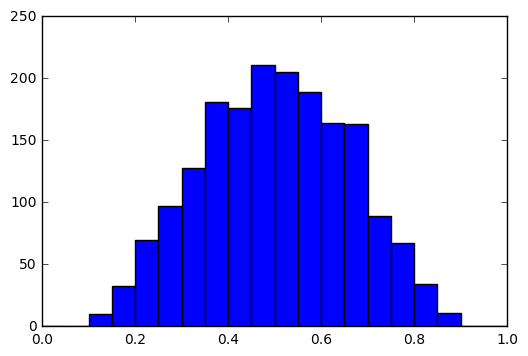

In [98]:
pyplot.hist(map(operator.itemgetter(1), model.predict_proba(tourney_x)),
            bins=numpy.linspace(0, 1, 21))